<a href="https://colab.research.google.com/github/chrisporras/graddiss/blob/dev/GradientDissentersHackathon2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon 2023
ML for Biomedical Data Science
Team Gradient Dissenters

Members: Audrey Lee, Christian Porras, Joy Jiang

# **MODEL 1: PRETRAINED RESNET50**



## I. Install and load Kaggle mammography

In [1]:
# Clone project git repo
!git clone https://github.com/chrisporras/graddiss.git

Cloning into 'graddiss'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 32 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), 287.41 KiB | 3.55 MiB/s, done.


In [2]:
# install Kaggle public api
! pip install -q kaggle
# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp ./graddiss/kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json
#Change the permissions of the file.
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2242         91  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1101         34  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 12:22:51          13877        465  1.0              
datascientistanna/customers-dataset          

In [3]:
!kaggle competitions download -c mammography-image-patch-classification-2023

 94% 435M/460M [00:01<00:00, 274MB/s]
100% 460M/460M [00:01<00:00, 257MB/s]


In [4]:
# data directory
!mkdir data
# unzip data there,
!unzip mammography-image-patch-classification-2023.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train_imgs/P000435.png  
  inflating: data/train_imgs/P000436.png  
  inflating: data/train_imgs/P000437.png  
  inflating: data/train_imgs/P000438.png  
  inflating: data/train_imgs/P000439.png  
  inflating: data/train_imgs/P000440.png  
  inflating: data/train_imgs/P000441.png  
  inflating: data/train_imgs/P000442.png  
  inflating: data/train_imgs/P000443.png  
  inflating: data/train_imgs/P000444.png  
  inflating: data/train_imgs/P000445.png  
  inflating: data/train_imgs/P000446.png  
  inflating: data/train_imgs/P000447.png  
  inflating: data/train_imgs/P000448.png  
  inflating: data/train_imgs/P000449.png  
  inflating: data/train_imgs/P000450.png  
  inflating: data/train_imgs/P000451.png  
  inflating: data/train_imgs/P000452.png  
  inflating: data/train_imgs/P000453.png  
  inflating: data/train_imgs/P000454.png  
  inflating: data/train_imgs/P000455.png  
  inflating: data/train_imgs/P000456.png  
  i

## II. Prepare data.
### A. Create datasets.

In [5]:
# Configuration class
class Config:
    resize = False
    batch_size = 64
    numworkers = 2

In [6]:
# CustomImageDataset class
import numpy as np
import os
import torch
from PIL import Image
import torchvision
from skimage import io, img_as_float32
import numpy as np
import torch
from skimage.io import imread

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)
        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        return torch.from_numpy(dup_img.copy())

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, transform=None):
        # Create one iterable that get be __getitemed__
        self.image_dir = image_dir
        self.df = df
        self.transform = transform # added transform

    def __len__(self): # Denotes the total number of samples
        # return self.df.shape[0] # orig
        return len(self.df) # try this

    # added this for normalization: https://towardsdatascience.com/train-a-neural-network-to-detect-breast-mri-tumors-with-pytorch-250a02be7777
    def normalize(self, image):
      image = image.astype(float) * 255. / image.max()
      # Convert float --> uint8. This maps pixel intensities from 0 to 255
      # Source: above and here: https://scikit-image.org/docs/stable/user_guide/data_types.html
      image = image.astype(np.uint8)
      return image

    def __getitem__(self, index): # Generates one sample of data
        
        # added this
        if torch.is_tensor(index):
          index = index.tolist()

        # Goes to image_tensor below
        image_path = os.path.join(self.image_dir, self.df.iloc[index]['img_name'])
        # image_og = Image.open(image_path)
        image_og = imread(image_path) # read in png or jpg

        # Normalize image
        image = self.normalize(image_og)

        # Convert to 3D tensor
        t = ToTensor3D()
        image = t(image)

        if self.transform:
          image = self.transform(image)
          # image = self.transform(image_og)

        label = torch.tensor(self.df.iloc[index]['label_num']) 

        # Resize, depending on the network
        if Config.resize:
            resize = torchvision.transforms.Resize(384)
            image = resize(image)
        
        return image, label

In [7]:
import pandas as pd

# New numeric labels.
labels_num = {'background': 0, 'calc_ben': 1, 'calc_mal': 2, 'mass_ben': 3, 'mass_mal': 4}

# Create datasets
traindf = pd.read_csv('data/train.csv') 
traindf['label_num'] = traindf['label'].map(labels_num)
train_dataset = CustomImageDataset('data/train_imgs', traindf)
testdf = pd.read_csv('data/test.csv') 

print(traindf.head())

        id     label     img_name  label_num
0  P000001  calc_ben  P000001.png          1
1  P000002  calc_ben  P000002.png          1
2  P000003  mass_ben  P000003.png          3
3  P000004  mass_mal  P000004.png          4
4  P000005  calc_mal  P000005.png          2


In [8]:
from torchvision import datasets, transforms

# Define transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Some data augmentation
    transforms.RandomHorizontalFlip(), # Some data augmentation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Examine paths.
label = traindf.iloc[1]['label']

image_path = os.path.join('data/train_imgs', traindf.iloc[1]['img_name'])
print(label)
print(image_path)

calc_ben
data/train_imgs/P000002.png


### B. Create dataloaders.

In [9]:
# Make datasets
train_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms)
train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                     [train_size, val_size])
test_dataset = CustomImageDataset('data/test_imgs', testdf)

# Make dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, Config.batch_size, 
                                           shuffle=True, num_workers=Config.numworkers)
val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
                                         shuffle=True, num_workers=Config.numworkers)

# Putting these into a dict format for easier use later
dataloaders = {"train": train_loader,
               "val": val_loader
               }

dataset_sizes = {"train": len(train_dataset),
                 "val": len(val_dataset)
                 }
# Run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


## III. Try ResNet50

In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [11]:
# Evaluate function
def model_eval(model, loader_, criterion):
    # Test the model
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader_:
            data = data.to(device) # Calculate on GPU
            target = target.to(device)
            output = model(data)
            eval_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item() # Compare to target and calculate accuracy

    eval_loss /= len(loader_)
    eval_acc = correct/len(loader_.dataset)
    return eval_loss, eval_acc

In [12]:
import time

# Initialize the model, loss function, and optimizer
model = models.resnet50(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Change the output to 5 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
# Get start time
start_time = time.time()

# Train the model
model = model.to(device)
best_acc = 0
epoch_ls = []
train_loss_ls = []
val_loss_ls = []
train_acc_ls = []
val_acc_ls = []

for epoch in range(25):
    model.train()
    train_loss = 0
    correct = 0

    # Gradient descent
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # Call backward propagation.
        optimizer.step() # Step in optimizer. 
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate metrics
    train_loss /= len(train_loader)
    train_acc = correct/len(train_loader.dataset)
    test_loss, test_acc = model_eval(model, val_loader, criterion)
    print('Train Epoch: {}\tLoss: {:.6f}\tAcc: {:.3f}'
          '\tVal - Loss:{:.6f}\tAcc:{:.3f}'.format(
              epoch, train_loss, train_acc, test_loss, test_acc))
    if test_acc > best_acc:
        torch.save(model.state_dict(), 'best_model1.pt') # Save the best model. 
    
    # Book-keep metrics
    epoch_ls.append(epoch)
    train_loss_ls.append(train_loss)
    val_loss_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(test_acc)
    
# Get end time
print("Total run time: %s seconds" % (time.time() - start_time))

# Test the model
# model.load_state_dict(torch.load('cifar_best_model.pt'))
# test_loss, test_acc = model_eval(model, test_loader, criterion)
# print('Test - Loss:{:.6f}\tAcc:{:.3f}'.format(test_loss, test_acc))

Train Epoch: 0	Loss: 1.102374	Acc: 0.569	Val - Loss:1.265659	Acc:0.514
Train Epoch: 1	Loss: 1.103946	Acc: 0.578	Val - Loss:1.943946	Acc:0.452
Train Epoch: 2	Loss: 1.078535	Acc: 0.582	Val - Loss:1.106796	Acc:0.562
Train Epoch: 3	Loss: 1.061070	Acc: 0.595	Val - Loss:1.228047	Acc:0.519
Train Epoch: 4	Loss: 1.035060	Acc: 0.592	Val - Loss:1.235606	Acc:0.548
Train Epoch: 5	Loss: 1.037379	Acc: 0.594	Val - Loss:1.263925	Acc:0.502
Train Epoch: 6	Loss: 1.037301	Acc: 0.607	Val - Loss:1.364021	Acc:0.543
Train Epoch: 7	Loss: 1.021361	Acc: 0.600	Val - Loss:1.126438	Acc:0.569
Train Epoch: 8	Loss: 1.025215	Acc: 0.607	Val - Loss:1.216108	Acc:0.535
Train Epoch: 9	Loss: 1.011624	Acc: 0.604	Val - Loss:1.608585	Acc:0.395
Train Epoch: 10	Loss: 1.012292	Acc: 0.598	Val - Loss:1.076980	Acc:0.576
Train Epoch: 11	Loss: 1.031103	Acc: 0.601	Val - Loss:1.452474	Acc:0.500
Train Epoch: 12	Loss: 1.017107	Acc: 0.604	Val - Loss:1.230483	Acc:0.501
Train Epoch: 13	Loss: 1.021235	Acc: 0.614	Val - Loss:1.053541	Acc:0.596
Tr

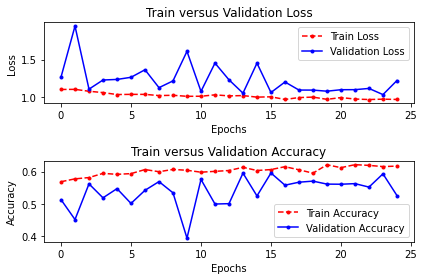

In [15]:
# Initialize subplots
import matplotlib.pyplot as plt
figure, axis = plt.subplots(2, 1)

# Plot
import matplotlib.pyplot as plt
axis[0].plot(epoch_ls, train_loss_ls, '.r--', label='Train Loss')
axis[0].plot(epoch_ls, val_loss_ls, '.b-', label='Validation Loss')
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_title("Train versus Validation Loss")
axis[0].legend()

axis[1].plot(epoch_ls, train_acc_ls, '.r--', label='Train Accuracy')
axis[1].plot(epoch_ls, val_acc_ls, '.b-', label='Validation Accuracy')
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_title("Train versus Validation Accuracy")
axis[1].legend()

# Apply labels 
plt.tight_layout()
plt.show()